<a href="https://colab.research.google.com/github/SamiraAsadzadeh/Ant-Colony-Optimization_TSP/blob/main/Project_Ant_Colony_Optimization_TSP_Shiraz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install haversine
!pip install pyswarms
!pip install geoplot
!pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 3.0 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
from collections import defaultdict
from haversine import haversine
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
import time
import pyswarms as ps
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import geoplot
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from sklearn.model_selection import ParameterGrid
import osmnx as ox

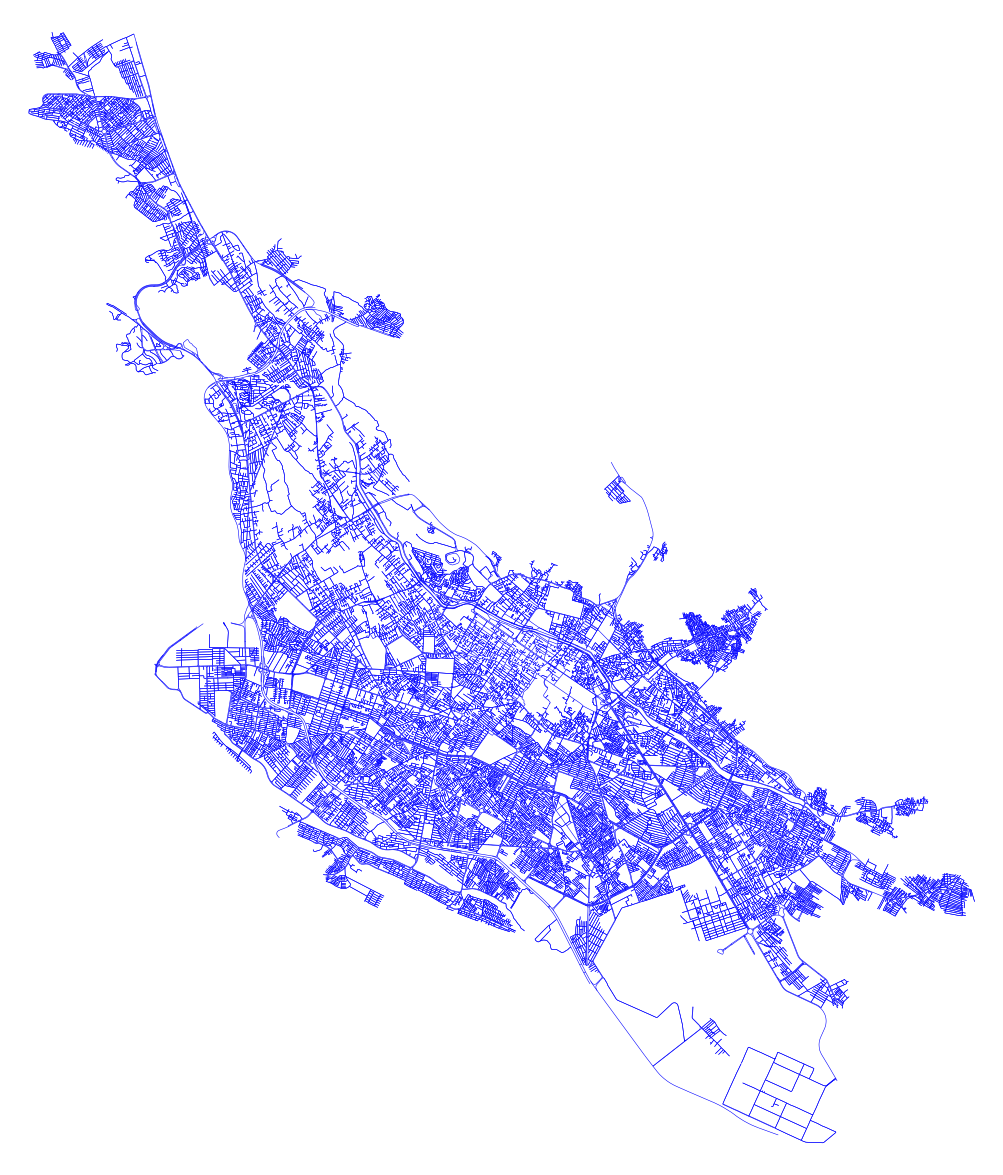

In [ ]:
G = ox.graph_from_place('shiraz, IRAN', network_type='drive')
fig, ax = ox.plot_graph(G, node_size=0, edge_color='b', bgcolor='w', edge_linewidth=0.4, figsize=(15,15))

In [ ]:
#here we select some sample location points for better visulize how the algorithm works
city_dic = {
    'Central Melli Bank': (29.61649, 52.54595),
    'Bank Saderat': (29.60543, 52.52875),
    'Bank Shahr': (29.60856, 52.54215),
    'Bank Maskan': (29.59240, 52.52477),
    'Bank Melat': (29.60318, 52.51538),
    'Bank Pasargad': (29.59474, 52.49289),
    'Bank Sepah': (29.62094, 52.50869),
    'Bank Sarmayeh': (29.63046, 52.52106)

}



# center the map around the first location in the dictionary
first_location_name, first_location_coords = next(iter(city_dic.items()))

# ایجاد نقشه
m = folium.Map(location=first_location_coords, zoom_start=13)

# نشانگر ها را روی بانک های مورد نظر با رنگ آبی قرار داده میشود و بانک خزانه که همان بانک مرکزی و سرپرسی هست با نشانگر قرمز مشخص میشود
for place, coords in city_dic.items():

    if place == 'Central Melli Bank':
        # If it is, create a marker with a red icon
        folium.Marker(
            location=coords,
            popup=place,
            icon=folium.Icon(color='red')
        ).add_to(m)
    else:
        # For all other places, use blue icons
        folium.Marker(
            location=coords,
            popup=place,
            icon=folium.Icon(color='blue')
        ).add_to(m)

# Display the map
m

In [ ]:
#Define the function for heavy-traffic, high-crime roads and unsafe road condition with a relatively high weight.
#Note here city means each location point
listcity=list(city_dic.keys())

def get_traffic_level(city1, city2):
    city1, city2 = listcity[city1], listcity[city2]
    #print(city1 , city2)

    if city1 == 'Central Melli Bank' and city2 == 'Bank Sarmayeh' or   city1 == 'Bank Sarmayeh' and city2 == 'Central Melli Bank' :

        return 10  # Here 10 represents a high traffic-level

    return 1 # 1 represents a normal traffic level for other paths

def get_criminal_level(city1, city2):
    city1, city2 = listcity[city1], listcity[city2]
    #print(city1 , city2)
    if city1 == 'Bank Saderat' and city2 == 'Bank Shahr' or   city1 == 'Bank Shahr' and city2 == 'Bank Saderat' :
    #if (city1, city2) in [('Bank Saderat', 'Bank Shahr'), ('Bank Shahr', 'Bank Saderat')]:
        # return float('inf')
        return 10  # Here 10 represents a high criminal-level
    return 1  # 1 represents a normal criminal level for other paths

def get_road_condition_level(city1, city2):
    city1, city2 = listcity[city1], listcity[city2]
    #print(city1 , city2)
    if city1 == 'Bank Maskan' and city2 == 'Bank Pasargad' or   city1 == 'Bank Pasargad' and city2 == 'Bank Maskan' :
    #if (city1, city2) in [('Bank Pasargad', 'Bank Maskan'),('Bank Maskan', 'Bank Pasargad')]:
        return 10 # Here 10 represents a unsafe road condition-level
    return 1 # 1 represents a normal condition for other paths



city_dic = {
    'Central Melli Bank': (29.61649, 52.54595),
    'Bank Saderat': (29.60543, 52.52875),
    'Bank Shahr': (29.60856, 52.54215),
    'Bank Maskan': (29.59240, 52.52477),
    'Bank Melat': (29.60318, 52.51538),
    'Bank Pasargad': (29.59474, 52.49289),
    'Bank Sepah': (29.62094, 52.50869),
    'Bank Sarmayeh': (29.63046, 52.52106)

}



edge_labels = {
    ('Central Melli Bank', 'Bank Sarmayeh'): 'Heavy Traffic',  # Label for heavy traffic
    ('Bank Saderat', 'Bank Shahr'): 'Low security',  # Label for high crime
    ('Bank Maskan', 'Bank Pasargad'): 'Unsafe to drive', # Label for unsafe road
}

#loop the dictionary twice and check to make sure each location are not the same to avoid it connects itself
distance_2cities = defaultdict(dict)
for city1,city1_coords in city_dic.items():
  for city2, city2_coords in city_dic.items():

    if city1 == city2:

      distance_2cities[city1][city2] = 0.0 # اگر دو شهر یکی هستند فاصله صفر میباشد
    else:
      #print(city1,city2)
      distance_2cities[city1][city2] = haversine(city1_coords, city2_coords) # محاسبه فاصله بین دو شهر
      #print( distance_2cities[city1][city2])

# Convert distance dictionary into a dataframe
distances_pandaFrame = pd.DataFrame(distance_2cities)

city_names=list(distances_pandaFrame.columns)#convert each column into list type. (each item in list can be anything)
distances=distances_pandaFrame.values #extract the values
distances_pandaFrame

2024-02-15 17:35:59,378 - llmx - INFO - Info: LLMX_CONFIG_PATH environment variable is not set to a valid config file. Using default config file at '/usr/local/lib/python3.10/dist-packages/llmx/configs/config.default.yml'.
2024-02-15 17:35:59,404 - llmx - INFO - Loaded config from '/usr/local/lib/python3.10/dist-packages/llmx/configs/config.default.yml'.


,Central Melli Bank,Bank Saderat,Bank Shahr,Bank Maskan,Bank Melat,Bank Pasargad,Bank Sepah,Bank Sarmayeh
Central Melli Bank,0.000000,2.068158,0.955237,3.371694,3.305206,5.671277,3.635591,2.863802
Bank Saderat,2.068158,0.000000,1.341408,1.499101,1.316594,3.665177,2.595176,2.880775
Bank Shahr,0.955237,1.341408,0.000000,2.460178,2.656309,5.004340,3.515307,3.175879
Bank Maskan,3.371694,1.499101,2.460178,0.000000,1.503690,3.093431,3.533813,4.247255
Bank Melat,3.305206,1.316594,2.656309,1.503690,0.000000,2.368317,2.078028,3.082694
Bank Pasargad,5.671277,3.665177,5.004340,3.093431,2.368317,0.000000,3.289465,4.815798
Bank Sepah,3.635591,2.595176,3.515307,3.533813,2.078028,3.289465,0.000000,1.596939
Bank Sarmayeh,2.863802,2.880775,3.175879,4.247255,3.082694,4.815798,1.596939,0.000000


In [ ]:
print(distances[0,1])

2.0681578408282895


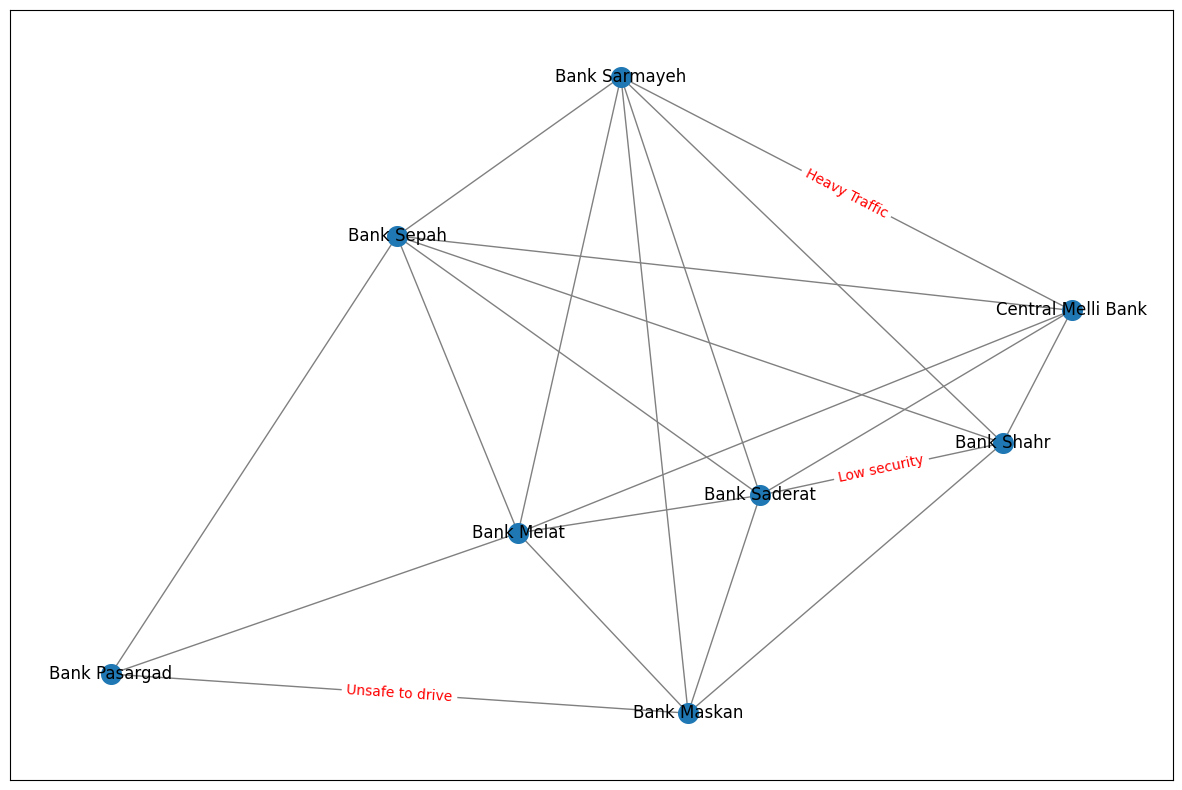

In [ ]:
#ایجاد شبکه گراف
G=nx.Graph()#create a networking graph with nodes as cities, distance as edges
#add edges to G


# Initialize an empty dictionary for the reversed value because Network assumes data in (horizontal,vertical)
reversed_dict = {}

# Loop and reverse each value
for key, value in city_dic.items():
    reversed_dict[key] = value[::-1]

for city1, city1_coords in city_dic.items():
    for city2, city2_coords in city_dic.items():
        if city1 != city2:  # Check to ensure cities are not the same to avoid it connects itself
            distance = distance_2cities[city1][city2]
            G.add_edge(city1, city2, weight=distance)

fig, ax = plt.subplots(figsize=(15,10))

#remobve some unnecessary connections
G.remove_edge('Central Melli Bank', 'Bank Maskan')
G.remove_edge('Central Melli Bank', 'Bank Pasargad')
G.remove_edge('Bank Sarmayeh', 'Bank Pasargad')
G.remove_edge('Bank Sepah', 'Bank Maskan')
G.remove_edge('Bank Pasargad', 'Bank Saderat')
G.remove_edge('Bank Pasargad', 'Bank Shahr')
G.remove_edge('Bank Melat', 'Bank Shahr')


# Create an independent copy
H = G.copy()

# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,#pos is the coordates of nodes
    with_labels=True,#display names
    edge_color="grey",
    node_size=200,
    width=1,#line thickness of edge
)

# Draw edge labels
nx.draw_networkx_edge_labels(
    H,
    pos=reversed_dict,
    edge_labels=edge_labels,
    font_color='red',
)

plt.show()

Create the map on the network graph to better visulize our picked points and doing the analysis

Define Cost Functions

In [ ]:

 #define the distance and traffic_volume as an extra heuristic infromation to be considered
traffic_volume = {
    ('Central Melli Bank', 'Bank Sarmayeh'): 10,  # High traffic path with a high weight

}
criminal_info = {
    ('Bank Saderat', 'Bank Shahr'): 10, # High criminal path with a high weight
}
road_info = {
    ('Bank Maskan', 'Bank Pasargad'): 10, # worse road condition with a high weight

}
def get_traffic_weight(path_segment, traffic_volume):

    # Retrieve the traffic weight for a given path segment from traffic_volume
    return traffic_volume.get(path_segment, 1) # مقدار پیش فرض یک را برای مقداری که وجود ندارد برگردان و چمانچه وجود دارد مقدار کلید را برگردان

def get_criminal_weight(path_segment, criminal_info):
    # Retrieve the criminal weight for a given path segment from criminal_info
    return criminal_info.get(path_segment, 1)  # default criminal weight is 1

def get_road_condition_weight(path_segment, road_info):
   # Retrieve the weather weight for a given path segment from weather_info
    return road_info.get(path_segment, 1) # default road condition weight is 1

#define cost function
def cost_function(path, distances, traffic_info, criminal_info, road_info):
    path_cost = 0
    for i in range(len(path) - 1):

        path_segment = (city_names[path[i]], city_names[path[i+1]])
        distance = distances[path[i], path[i+1]]

        traffic_weight = get_traffic_weight(path_segment, traffic_info)

        criminal_weight = get_criminal_weight(path_segment, criminal_info)

        road_condition_weight = get_road_condition_weight(path_segment, road_info)
        #if traffic_weight!=10 and criminal_weight!=10 and road_condition_weight!= 10:
        path_cost += distance + traffic_weight + criminal_weight + road_condition_weight
        #print(path_cost)


    return path_cost

In [ ]:
#تولید جمعیت
#paths is initialized as a NumPy array to store the path for each ant.
#The dimensions are (ants, city_count), representing the number of ants and the number of cities, respectively.
city_count = 8
ants = 30
alpha = 0.5
beta = 1.5 #here we assign a relatively high beta value for increaseing the power of the heuristic information
pheromones = np.ones((city_count, city_count))


def ant_tour(pheromones):
    all_possible_paths = np.empty((30, city_count+1), dtype=int) #an empty 2D array to store all possible paths.
    #for each ant:
    for ant in range(ants):
      path = [0] #all ants need to start from 1st city, let's assume it is 0 stored in a list
      unvisited_cities = list(range(1, city_count)) #unvisited_cities = [1,2,...,7]

      while unvisited_cities:
          current_city = path[-1] #the most recent city that ant visited (for itration 1, path[-1] is 0)
          probabilities = []

          for city in unvisited_cities:
            #print('city:',city)
            #print('current_city', current_city)
            tau = pheromones[current_city, city]#here pheromones is a ones matrix

            distance_heuristic = distances[current_city, city]

            traffic_heuristic = get_traffic_level(current_city, city)


            criminal_heuristic = get_criminal_level(current_city, city)


            road_condition_heuristic = get_road_condition_level(current_city, city)


            eta = 1/(distance_heuristic + traffic_heuristic + criminal_heuristic + road_condition_heuristic) #compute eta by including heuristic information in the denominator.
            #print ('eta:', eta, current_city, city)

            tau_eta = (tau** alpha)*(eta ** beta)
         #   print('tau_eta:' ,tau_eta)
            if traffic_heuristic==10 or criminal_heuristic==10 or road_condition_heuristic== 10:
              tau_eta = 0.00001

            probabilities.append(tau_eta) #compute probability of the ant to select the next path

          sumproblities = sum(probabilities)
          list2 = []
          for element in probabilities:
              result = element / sumproblities
              list2.append(result)
          #print('dorDovom:' ,list2)

          probabilities = list2

          next_city = random.choices(unvisited_cities, weights=probabilities)[0]

          unvisited_cities.remove(next_city)
          path.append(next_city) #record the path(route)for each ant


      path.append(0)

      for i in range(len(path)-1):
        if path[i] == 0 and path[i+1] == 7 :
            empty = path[i+1]
            path[i+1] = path[i+2]
            path[i+2]= empty

        if path[i] == 7 and path[i+1] == 0 :
            empty = path[i]
            path[i] = path[i-1]
            path[i-1]= empty
        #print('patch:', path)
      all_possible_paths[ant] = path #store the recorded path into paths matrix


    return all_possible_paths

In [ ]:
evaporation_rate = 0.5
Q=1

def update_pheromones(distances_paths, all_possible_paths, pheromones):
    delta_pheromones = np.zeros((city_count, city_count))

    for i in range(ants):
        for j in range(city_count-1):
            #here update pheronmone between each two city (path)based on each ant's route
            delta_pheromones[all_possible_paths[i, j], all_possible_paths[i, j+1]] += Q / distances_paths[i]
        delta_pheromones[all_possible_paths[i, -1], all_possible_paths[i, 0]] += Q / distances_paths[i]

    update_phero_values=(1 - evaporation_rate) * pheromones + delta_pheromones
    return update_phero_values

In [ ]:
def run_ACO(distances, ants, iterations, alpha, beta, evaporation_rate, Q):
    start_time = time.time()
    pheromones = np.ones((city_count, city_count))
    best_path = None
    best_cost = float('inf')
    best_costs_per_iteration = []

    for iteration in range(iterations):
        all_possible_paths = ant_tour(pheromones)


        #uncomment this if you do not want the path to consider extra heuristic information of avoiding heavy traffic path
        # distances_paths = np.array([cost_function(path, distances) for path in all_possible_paths])

        # consider traffic_flow, criminal, road_condition
        distances_paths = np.array([cost_function(path, distances, traffic_volume, criminal_info, road_info) for path in all_possible_paths])
        min_idx = distances_paths.argmin()
        min_distance = distances_paths[min_idx]
        #print('min_distance:', min_distance)

        if min_distance < best_cost:
            best_cost = min_distance
            best_path = all_possible_paths[min_idx]

        best_costs_per_iteration.append(best_cost)

        # Update pheromones
        pheromones = update_pheromones(distances_paths, all_possible_paths, pheromones)
        end_time = time.time()
        runtime = end_time - start_time
    return best_path, best_cost, best_costs_per_iteration, runtime


In [ ]:
param_grid = {
    'iteration': [10, 50, 100, 200],
    'alpha': [0.3, 0.5, 1.0],
    'beta': [0.3, 0.5, 1.5],
    'rho': [0.3, 0.5, 1.0]
}
time_list = []
runtimes = []
cost_list = []
beta_values = []
grid = ParameterGrid(param_grid)
best_score = float('inf')
for params in grid:
    # Initialize the optimizer with the current parameters
    start_time = time.time()
    best_path, best_cost, cost_history, runtime = run_ACO(distances, ants=30, iterations=params['iteration'], alpha=params['alpha'], beta=params['beta'], evaporation_rate=params['rho'], Q=100)
    total_time = time.time() - start_time
    time_list.append(total_time)
    runtimes.append(runtime)
    beta_values.append(beta)
    cost_list.append(cost_history)
    # If the score is better than the best score, update the best score and best parameters
    if best_cost < best_score:
        best_score = best_cost
        best_params = params
    print('Test param:', params)
    print('Cost:', best_cost)

print(f'Best score: {best_score}')
print(f'Best parameters: {best_params}')

Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 10, 'rho': 0.3}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 10, 'rho': 0.5}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 10, 'rho': 1.0}
Cost: 42.35521885988172
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 50, 'rho': 0.3}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 50, 'rho': 0.5}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 50, 'rho': 1.0}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 100, 'rho': 0.3}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 100, 'rho': 0.5}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 100, 'rho': 1.0}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 200, 'rho': 0.3}
Cost: 40.45678664557441
Test param: {'alpha': 0.3, 'beta': 0.3, 'iteration': 200, 'rho': 0

In [ ]:
#print the route and its length
ants_tour=[]
for i in best_path:
  ants_tour.append(city_names[i])
# ants_tour=[city_names[i] for i in best_path]
route_names = " → ".join(ants_tour)
print("route_index:", best_path)
print("route_names:", route_names)
print("route length:", np.round(best_cost, 3))#round it to 3 decimal places
print("time:", np.round(total_time, 3))

route_index: [0 1 3 4 5 6 7 2 0]
route_names: Central Melli Bank → Bank Saderat → Bank Maskan → Bank Melat → Bank Pasargad → Bank Sepah → Bank Sarmayeh → Bank Shahr → Central Melli Bank
route length: 40.457
time: 0.701


The figure below show the route successfully go around (detour) the high-crime road and high-traffic road to improve the safety of students

[('Central Melli Bank', 'Bank Saderat'), ('Bank Saderat', 'Bank Maskan'), ('Bank Maskan', 'Bank Melat'), ('Bank Melat', 'Bank Pasargad'), ('Bank Pasargad', 'Bank Sepah'), ('Bank Sepah', 'Bank Sarmayeh'), ('Bank Sarmayeh', 'Bank Shahr'), ('Bank Shahr', 'Central Melli Bank')]


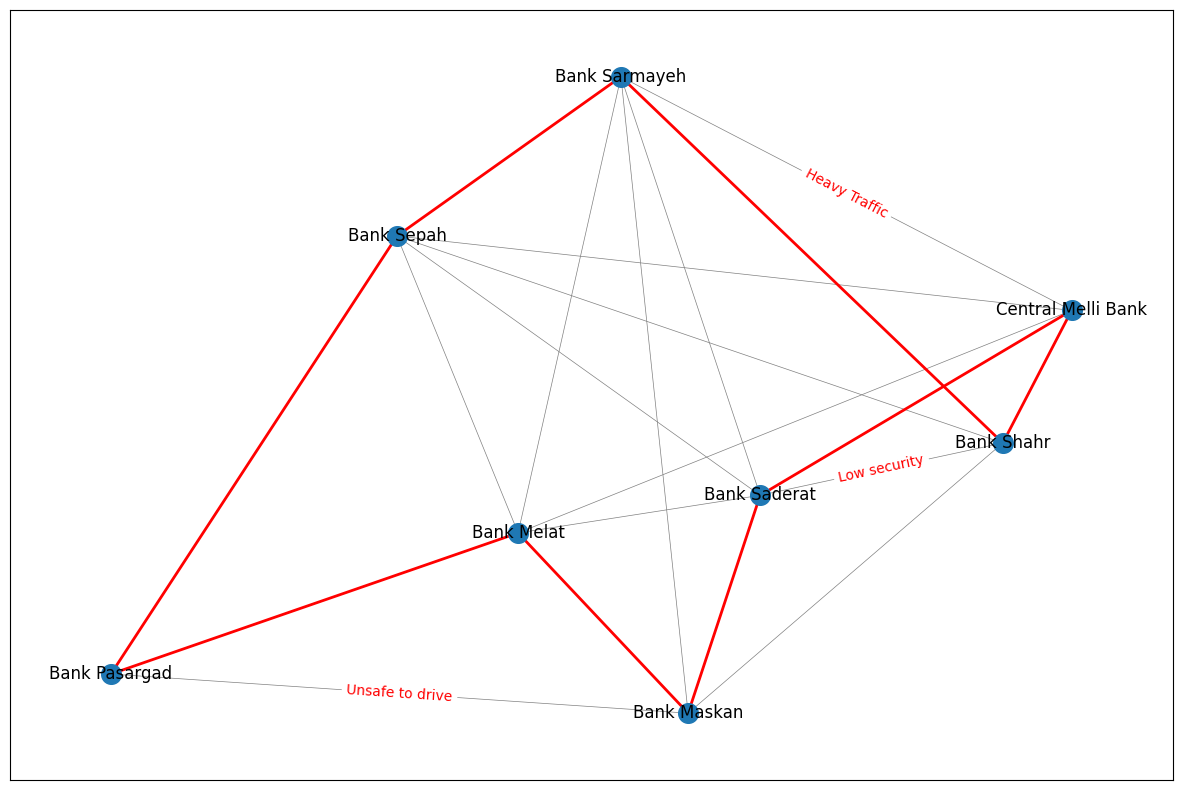

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
# H = G.copy()


# Initialize an empty dictionary for the reversed value because Network assumes data in (horizontal,vertical)
reversed_dict = {}
for key, value in city_dic.items():# Loop and reverse each value
    reversed_dict[key] = value[::-1]

#store ants_tour
edge_list =list(nx.utils.pairwise(ants_tour))
print(edge_list)
nx.draw_networkx_edges(H, pos=reversed_dict, edge_color="gray", width=0.5)

edge_labels = {
    ('Central Melli Bank', 'Bank Sarmayeh'): 'Heavy Traffic',  # Label for heavy traffic
    ('Bank Saderat', 'Bank Shahr'): 'Low security',  # Label for high crime
    ('Bank Maskan', 'Bank Pasargad'): 'Unsafe to drive', # Label for unsafe road
}

# Draw the network
ax=nx.draw_networkx(
    H,
    pos=reversed_dict,#pos is the coordates of nodes
    with_labels=True,#display names
    edgelist=edge_list, #only draw the tour that is stored in the edge_list
    edge_color="red",
    node_size=200,
    width=2,#thickness of edge
)

nx.draw_networkx_edge_labels(
    H,
    pos=reversed_dict,
    edge_labels=edge_labels,
    font_color='red',
)
plt.show()

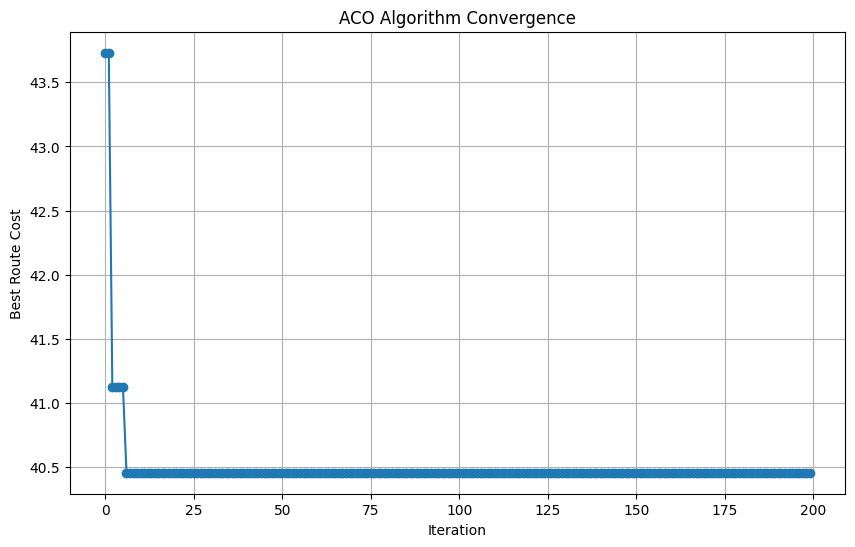

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Best Route Cost')
plt.title('ACO Algorithm Convergence')
plt.grid(True)
plt.show()


In [ ]:
beta_values = [0.3, 0.5, 1.5]
runtimes = []
cost_list = []

for beta in beta_values:
    best_path, best_cost, cost_history, runtime = run_ACO(distances, ants=30, iterations=10, alpha=0.3, beta=beta, evaporation_rate=0.3, Q=1)
    runtimes.append(runtime)
    cost_list.append(cost_history)



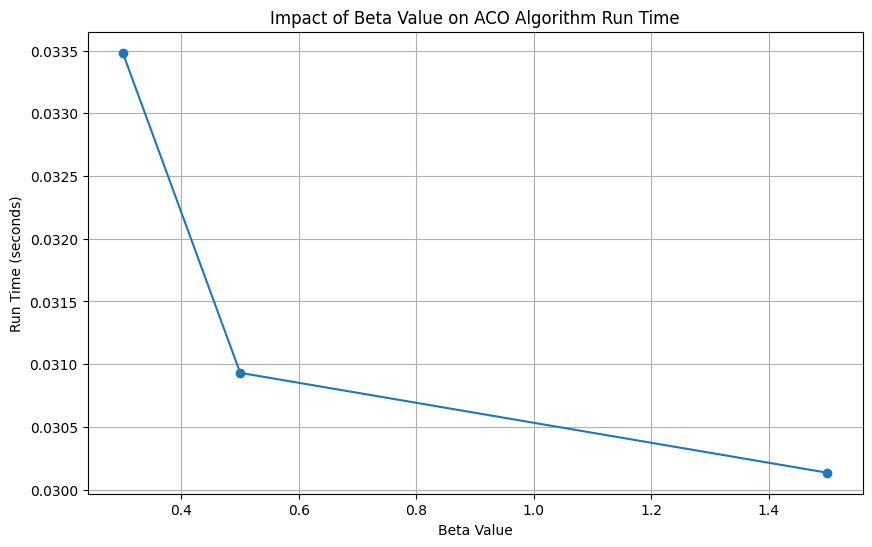

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(beta_values, runtimes, marker='o')
plt.xlabel('Beta Value')
plt.ylabel('Run Time (seconds)')
plt.title('Impact of Beta Value on ACO Algorithm Run Time')
plt.grid(True)
plt.show()


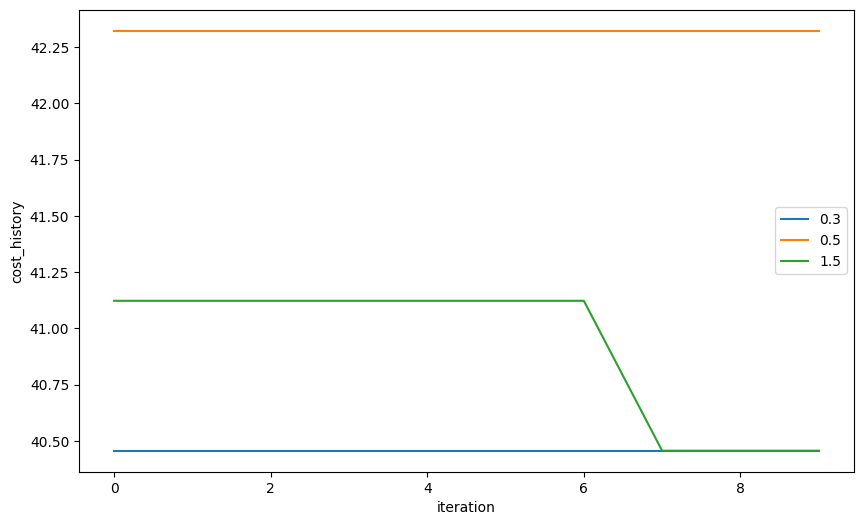

In [ ]:
plt.figure(figsize=(10, 6))
for i in range(len(cost_list)):
    plt.plot(cost_list[i],label=beta_values[i])

plt.xlabel("iteration")
plt.ylabel("cost_history")
plt.legend()
plt.show()